In [ ]:
!pip install livelossplot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Import basic required packages
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import time
import seaborn as sns
import os
from datetime import datetime as dt


# Import Tensor Flow and Scikit
import tensorflow as tf
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold
from keras.models import Model
from keras.optimizers import Adam
from keras.applications import vgg16, vgg19, resnet, inception_v3, MobileNetV3Small, mobilenet_v3
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Dense, Dropout, Flatten
from keras.utils import to_categorical
from livelossplot.inputs.keras import PlotLossesCallback
from tensorflow.keras import backend as K

import warnings
warnings.filterwarnings("ignore")

## 1. Load the datasets

For the project, we provide a training set with 50000 images in the directory `../data/images/` with:
- noisy labels for all images provided in `../data/noisy_label.csv`;
- clean labels for the first 10000 images provided in `../data/clean_labels.csv`. 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# [DO NOT MODIFY THIS CELL]

# load the images
n_img = 50000
n_noisy = 40000
n_clean_noisy = n_img - n_noisy
#imgs = np.empty((n_img,32,32,3))
#for i in range(n_img):
    #img_fn = f'../data/images/{i+1:05d}.png'
    #imgs[i,:,:,:]=cv2.cvtColor(cv2.imread(img_fn),cv2.COLOR_BGR2RGB)

 #converting above data to numpy file 'imgs.npy'   

# load the labels
#clean_labels = np.genfromtxt('../data/clean_labels.csv', delimiter=',', dtype="int8")
#noisy_labels = np.genfromtxt('../data/noisy_labels.csv', delimiter=',', dtype="int8")

In [ ]:
# Converting the arrays from images above and reload
data_path = '/content/drive/MyDrive/data/'
imgs = np.load(data_path + 'imgs.npy')

In [ ]:
# load the labels
clean_labels = np.genfromtxt(data_path + 'clean_labels.csv', delimiter=',', dtype="int8")
noisy_labels = np.genfromtxt(data_path + 'noisy_labels.csv', delimiter=',', dtype="int8")

For illustration, we present a small subset (of size 8) of the images with their clean and noisy labels in `clean_noisy_trainset`. You are encouraged to explore more characteristics of the label noises on the whole dataset. 

Clean labels:
 frog truck truck  deer   car   car  bird horse
Noisy labels:
  cat   dog truck  frog   dog  ship  bird  deer


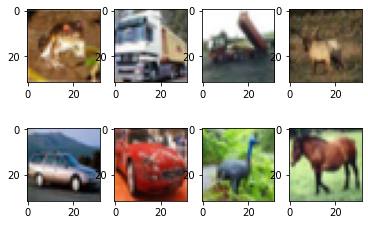

In [ ]:
# [DO NOT MODIFY THIS CELL]

fig = plt.figure()

ax1 = fig.add_subplot(2,4,1)
ax1.imshow(imgs[0]/255)
ax2 = fig.add_subplot(2,4,2)
ax2.imshow(imgs[1]/255)
ax3 = fig.add_subplot(2,4,3)
ax3.imshow(imgs[2]/255)
ax4 = fig.add_subplot(2,4,4)
ax4.imshow(imgs[3]/255)
ax1 = fig.add_subplot(2,4,5)
ax1.imshow(imgs[4]/255)
ax2 = fig.add_subplot(2,4,6)
ax2.imshow(imgs[5]/255)
ax3 = fig.add_subplot(2,4,7)
ax3.imshow(imgs[6]/255)
ax4 = fig.add_subplot(2,4,8)
ax4.imshow(imgs[7]/255)

# The class-label correspondence
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# print clean labels
print('Clean labels:')
print(' '.join('%5s' % classes[clean_labels[j]] for j in range(8)))
# print noisy labels
print('Noisy labels:')
print(' '.join('%5s' % classes[noisy_labels[j]] for j in range(8)))


## 2. The predictive model

We consider a baseline model directly on the noisy dataset without any label corrections. RGB histogram features are extracted to fit a logistic regression model.

### 2.1. Baseline Model

Logistic regression is the classification algorithm that is usually used to predict probability of binary categorical outcome. In the image classification context, input features are the pixel values of images and the outcomes are class of label images. 

In [ ]:
# [DO NOT MODIFY THIS CELL]
# The dataset consists of two parts: a target vector of noisy labels (y), and a feature matrix of RGB histograms for each image. (x)
# RGB histogram dataset construction
no_bins = 6
bins = np.linspace(0,255,no_bins) # the range of the rgb histogram
target_vec = np.empty(n_img)
feature_mtx = np.empty((n_img,3*(len(bins)-1)))
i = 0
for i in range(n_img):
    # The target vector consists of noisy labels
    target_vec[i] = noisy_labels[i]
    
    # Use the numbers of pixels in each bin for all three channels as the features
    feature1 = np.histogram(imgs[i][:,:,0],bins=bins)[0] 
    feature2 = np.histogram(imgs[i][:,:,1],bins=bins)[0]
    feature3 = np.histogram(imgs[i][:,:,2],bins=bins)[0]
    
    # Concatenate three features
    feature_mtx[i,] = np.concatenate((feature1, feature2, feature3), axis=None)
    i += 1 # Each row in the feature matrix corresponds to a single image in the dataset, and the columns represent the RGB histogram features for that image. 

In [ ]:
# [DO NOT MODIFY THIS CELL]
# Train a logistic regression model 
clf = LogisticRegression(random_state=0).fit(feature_mtx, target_vec)

For the convenience of evaluation, we write the following function `predictive_model` that does the label prediction. **For your predictive model, feel free to modify the function, but make sure the function takes an RGB image of numpy.array format with dimension $32\times32\times3$  as input, and returns one single label as output.**

In [ ]:
# [DO NOT MODIFY THIS CELL]
def baseline_model(image):
    '''
    This is the baseline predictive model that takes in the image and returns a label prediction
    '''
    feature1 = np.histogram(image[:,:,0],bins=bins)[0]
    feature2 = np.histogram(image[:,:,1],bins=bins)[0]
    feature3 = np.histogram(image[:,:,2],bins=bins)[0]
    feature = np.concatenate((feature1, feature2, feature3), axis=None).reshape(1,-1)
    return clf.predict(feature)

Clean labels:
 frog truck truck  deer   car   car  bird horse
Predicted baseline labels:
 frog  ship truck  frog  ship   cat  deer horse


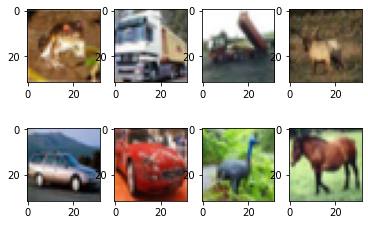

In [ ]:
fig = plt.figure()

ax1 = fig.add_subplot(2,4,1)
ax1.imshow(imgs[0]/255)
ax2 = fig.add_subplot(2,4,2)
ax2.imshow(imgs[1]/255)
ax3 = fig.add_subplot(2,4,3)
ax3.imshow(imgs[2]/255)
ax4 = fig.add_subplot(2,4,4)
ax4.imshow(imgs[3]/255)
ax1 = fig.add_subplot(2,4,5)
ax1.imshow(imgs[4]/255)
ax2 = fig.add_subplot(2,4,6)
ax2.imshow(imgs[5]/255)
ax3 = fig.add_subplot(2,4,7)
ax3.imshow(imgs[6]/255)
ax4 = fig.add_subplot(2,4,8)
ax4.imshow(imgs[7]/255)

print('Clean labels:')
print(' '.join('%5s' % classes[clean_labels[j]] for j in range(8)))
print('Predicted baseline labels:')
print(' '.join('%5s' % classes[int(baseline_model(imgs[j])[0])] for j in range(8)))

### 2.2. Model I

+ In this model, the first thing to do is to implement data augmentation by resizing the images to 75 x 75 x 3 to capture more details and features -- increasing the spatial resolution. This array of 'imgs_load' is then saved under 'img_load.py' and splitted under 75:25 ratio. 

In [ ]:
#imgs_load = np.empty((n_img,75,75,3))
#for i in range(n_img):
    #img_fn = f'../data/images/{i+1:05d}.png'
    #imgs_load[i,:,:,:]=cv2.resize(cv2.imread(img_fn),(75,75),interpolation=cv2.INTER_CUBIC)
    

In [ ]:
#Re-load the imgs_load.npy under imgs_load
imgs_load = np.load(data_path + 'imgs_load.npy')

+ InceptionV3 requires its instances to be pre-processed using 'inception_v3.preprocess_input' built in function. The process in this function comprised of resizing images to 299 x 299 pixels, scalling the pixel values to the range [-1,1], and applying some normalization for the color channels RGB. 

In [ ]:
imgs_inception = inception_v3.preprocess_input(imgs_load)

In [ ]:
# splitting the data into 75:25 ratio
imgs_inception_train, imgs_inception_test, noisy_labels_train, noisy_labels_test = train_test_split(imgs_load, noisy_labels, test_size = 0.25, random_state = 42)

+ The next step is to load Inception V3 model with some modifications. First, it provides option to freze the pre-tained layers so that the features will follow those of ImageNet. Second, the fully-connected layers will be built based on new architecture with ReLU activation and drop out rate to prevent overfitting. 

In [ ]:
# loading the inception_v3 model
def create_model_inception(input_shape, n_classes, optimizer, fine_tune):
    """
    Deploy a compilation of a model integrated with inception_v3 pretrained layers
    
    - input_shape: the shape of input images (width, height, color channels) in tuple
    - n_classes: number of classes for the output layer in integer
    - optimizer:  optimizer to use for training. Defaults to 'RMSProp', in this case this model uses Adam in string
    - fine_tune: The number of pre-trained layers to unfreeze in string.
               If set to 0, all pretrained layers will freeze during training & only top layers (dense/fc) will be trained. 
               Freezing pre-trained layers means that the weights will not be updated and features from ImageNet will be kept fixed. 
    """

    # In pretrained convolutional layers, weights are loaded using the ImageNet weights.
    # Excluding the fully-connected layers to make customization for the model -- matching the classes that we aim so the model can learn different task not only Image Net. 
    conv_base = inception_v3.InceptionV3(include_top=False,
                            weights='imagenet',input_shape=input_shape)
    
    # Defines how many layers to freeze during training.
    # Layers in the convolutional base are switched from trainable to non-trainable
    # If the fine_tune is set to 0, all pre-trained layers will be frozen and left un-trainable, by default using ImageNet features.
    # Otherwise, the last n layers will be made available for training.
    if fine_tune > 0:
        for layer in conv_base.layers[:-fine_tune]:
            layer.trainable = False
    else:
        for layer in conv_base.layers:
            layer.trainable = False

    # Customize the architecture of the top_model(i.e. fully-connected layers or Dense layers) 
    # The intuition is to use the 'conv_base' outputs and flattening them.
    # The method uses 'bootstrapping' approach to a new top_model onto the pretrained layers.
    top_model = conv_base.output
    top_model = Flatten()(top_model)
    top_model = Dense(n_classes*8, activation='relu')(top_model) #the more the nodes, the higher chance of the model to learn complex non-linear relationships
    top_model = Dense(n_classes*4, activation='relu')(top_model) #reduce the dimensionality from previous layers
    top_model = Dropout(0.2)(top_model) #20% of the input will be randomly set to 0 to prevent overfitting
    output_layer = Dense(n_classes, activation='softmax')(top_model)
    
    # Compiling the convolutional base and new fully-connected layers into a Model object.
    model = Model(inputs=conv_base.input, outputs=output_layer)

    # Compiles the model for training.
    model.compile(optimizer=optimizer, 
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model


input_shape = (75, 75,3)
n_classes=10
optim = Adam(learning_rate=0.001) 
inception_model = create_model_inception(input_shape, n_classes, optim, fine_tune = 0)

87910968/87910968 [==============================] - 0s 0us/step


+ In training the model, the data input is divided into training sets and text sets froom img_inception_training data. Some of the callback functions are used to prevent overfitting and endorse the model to learn more generalized patterns. 

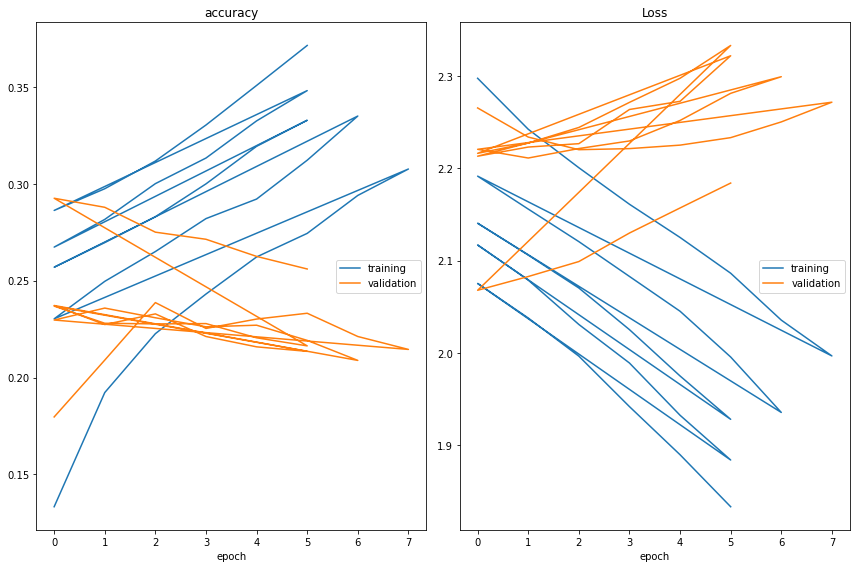

accuracy
	training         	 (min:    0.133, max:    0.371, cur:    0.371)
	validation       	 (min:    0.180, max:    0.292, cur:    0.256)
Loss
	training         	 (min:    1.833, max:    2.298, cur:    1.833)
	validation       	 (min:    2.068, max:    2.333, cur:    2.184)
235/235 [==============================] - 5s 18ms/step - loss: 2.1841 - accuracy: 0.2487
Model evaluation  [2.184081554412842, 0.2486666738986969]
Model Training Time: 3.96 mins


In [ ]:
# Train the incep model
# ModelCheckpoint: callback function to save the best model weights based on validation loss so that the model can continue training from the best weights.  
# EarlyStopping: another callback function to monitor validation loss during training and stop it earlier if the metric stops improving after 5 epochs. 
# PlotLossesCallBack: callback function, not too essential, but beneficial to plot the training and validation loss curve. 
start = time.time()

inception_checkpoint = ModelCheckpoint(filepath= data_path + 'inception.weights.best.hdf5', save_best_only=True, verbose=1)
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, mode='min')
plot_loss = PlotLossesCallback()

# Splitting the data with K-Fold cross validation method with 5 fold
# Each fold is trained with 'inception_model' for 20 epochs and batch size of 128
# tf.one_hot is to convert noisy labels into categorical format
# validation_split is a hyperparameter to specify the fraction of input data to be used as validation set

n_split=5

for train_index,test_index in KFold(n_split).split(imgs_inception_train):
  x_train,x_test=imgs_inception_train[train_index],imgs_inception_train[test_index]
  y_train,y_test=noisy_labels_train[train_index],noisy_labels_train[test_index]
  
  inception_fit = inception_model.fit(x_train, 
                            tf.one_hot(y_train,10),
                            batch_size=128, # Mini-batch gradient descent
                            epochs=20,# 20
                            validation_split=0.2, 
                            callbacks=[inception_checkpoint, early_stop, plot_loss],
                            verbose=1)
  K.clear_session() 

# Evaluates the trained inception model with x_text or test set that's not used within training mdoel
  print('Model evaluation ',inception_model.evaluate(x_test,tf.one_hot(y_test,10)))

print('Model Training Time:', round((time.time() - start)/60, 2), 'mins')

+ Deploy prediction and assess accuracy of the model using the best weights from previous model and test datasets. 

In [ ]:
# Prediction & Accuracy
start = time.time()
inception_model.load_weights(data_path + 'inception.weights.best.hdf5')
inception_preds = inception_model.predict(imgs_inception_test)
inception_pred_classes = np.argmax(inception_preds, axis=1)
print('Model Test Time:', round((time.time() - start)/60, 2), 'mins')
inception_acc = accuracy_score(noisy_labels_test, inception_pred_classes)
print("incep Model Accuracy: {:.2f}%".format(inception_acc * 100))

391/391 [==============================] - 9s 18ms/step
Model Test Time: 0.23 mins
incep Model Accuracy: 22.98%


In [ ]:
# saving the model 
inception_model.save('saved_models/incep/inception_model')

In [ ]:
# [BUILD A MORE SOPHISTICATED PREDICTIVE MODEL]
def model_I(image):
    '''
    Model 1 uses Inception V3 methods of CNN
    '''
    inception_model.load_weights(data_path + 'inception.weights.best.hdf5')
    inception_preds = inception_model.predict([np.expand_dims(image, axis=0)],verbose=0); #adding batch size in the array, required by InceptionV3
    inception_pred_classes = np.argmax(inception_preds, axis=1) #return the highest probability
    return int(inception_pred_classes[0])


Clean labels:
 frog truck truck  deer   car   car  bird horse
Predicted baseline labels:
  cat  ship plane  deer   car  deer horse horse


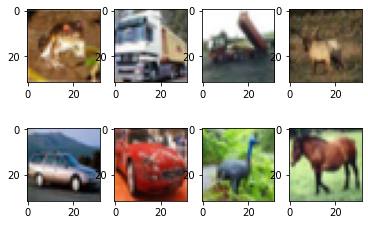

In [ ]:
fig = plt.figure()

ax1 = fig.add_subplot(2,4,1)
ax1.imshow(imgs[0]/255)
ax2 = fig.add_subplot(2,4,2)
ax2.imshow(imgs[1]/255)
ax3 = fig.add_subplot(2,4,3)
ax3.imshow(imgs[2]/255)
ax4 = fig.add_subplot(2,4,4)
ax4.imshow(imgs[3]/255)
ax1 = fig.add_subplot(2,4,5)
ax1.imshow(imgs[4]/255)
ax2 = fig.add_subplot(2,4,6)
ax2.imshow(imgs[5]/255)
ax3 = fig.add_subplot(2,4,7)
ax3.imshow(imgs[6]/255)
ax4 = fig.add_subplot(2,4,8)
ax4.imshow(imgs[7]/255)

print('Clean labels:')
print(' '.join('%5s' % classes[clean_labels[j]] for j in range(8)))
print('Predicted baseline labels:')
print(' '.join('%5s' % classes[model_I(imgs_inception[j])] for j in range(8)))

### 2.3. Model II

In [ ]:
# [ADD WEAKLY SUPERVISED LEARNING FEATURE TO MODEL I]

# write your code here...

def model_II(image):
    '''
    This function should takes in the image of dimension 32*32*3 as input and returns a label prediction
    '''
    # write your code here...

## 3. Evaluation

For assessment, we will evaluate your final model on a hidden test dataset with clean labels by the `evaluation` function defined as follows. Although you will not have the access to the test set, the function would be useful for the model developments. For example, you can split the small training set, using one portion for weakly supervised learning and the other for validation purpose. 

In [ ]:
# [DO NOT MODIFY THIS CELL]
def evaluation(model, test_labels, test_imgs):
    y_true = test_labels
    y_pred = []
    for image in test_imgs:
        y_pred.append(model(image))
    print(classification_report(y_true, y_pred))

In [ ]:
# [DO NOT MODIFY THIS CELL]
# This is the code for evaluating the prediction performance on a testset
# You will get an error if running this cell, as you do not have the testset
# Nonetheless, you can create your own validation set to run the evlauation
n_test = 10000
test_labels = np.genfromtxt('../data/test_labels.csv', delimiter=',', dtype="int8")
test_imgs = np.empty((n_test,32,32,3))
for i in range(n_test):
    img_fn = f'../data/test_images/test{i+1:05d}.png'
    test_imgs[i,:,:,:]=cv2.cvtColor(cv2.imread(img_fn),cv2.COLOR_BGR2RGB)
evaluation(baseline_model, test_labels, test_imgs)

In [ ]:
!wget -nc https://raw.githubusercontent.com/brpy/colab-pdf/master/colab_pdf.py
from colab_pdf import colab_pdf
colab_pdf('Inception V3.ipynb')

--2023-03-08 21:06:10--  https://raw.githubusercontent.com/brpy/colab-pdf/master/colab_pdf.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1864 (1.8K) [text/plain]
Saving to: ‘colab_pdf.py’

colab_pdf.py        100%[===================>]   1.82K  --.-KB/s    in 0s      

2023-03-08 21:06:11 (28.6 MB/s) - ‘colab_pdf.py’ saved [1864/1864]





E: Unable to locate package texlive-generic-recommended
[NbConvertApp] WARNING | pattern '$notebookpath$file_name' matched no files
This application is used to convert notebook files (*.ipynb)
        to various other formats.


Options
The options below are convenience aliases to configurable class-options,
as listed in the "Equivalent to" description-line of the aliases.
To see all configurable class-options for som

'File Download Unsuccessful. Saved in Google Drive'

The overall accuracy is $0.24$, which is better than random guess (which should have a accuracy around $0.10$). For the project, you should try to improve the performance by the following strategies:

- Consider a better choice of model architectures, hyperparameters, or training scheme for the predictive model;
- Use both `clean_noisy_trainset` and `noisy_trainset` for model training via **weakly supervised learning** methods. One possible solution is to train a "label-correction" model using the former, correct the labels in the latter, and train the final predictive model using the corrected dataset.
- Apply techniques such as $k$-fold cross validation to avoid overfitting;
- Any other reasonable strategies.